# visualizing synthetic landscape + SGD

## imports

### mount drive


In [1]:
# if needed
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### pip installs

In [2]:
!pip install scanpy moscot ott-jax diffrax napari anndata -q
!pip install "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 5.8 MB/s eta 0:00:00
   ━━━━

### imports

In [3]:
import math, napari, numpy as np
import pandas as pd

from scipy.optimize import minimize
from scipy.ndimage import minimum_filter




import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import sys, pathlib
fh_hmot = "/content/drive/Othercomputers/numac/GitHub/HM-OT" # filehandle for HM-OT
project_root = pathlib.Path(fh_hmot)
sys.path.insert(0, fh_hmot)
sys.path.insert(0, str(project_root / "src"))
from utils.waddington import viewer, visual, minima, simulation, differentiation, metrics
from utils.waddington import seed_everything
import src.plotting as plotting

## set seed

In [4]:
# Set global seed for reproducibility
GLOBAL_SEED = 44
# np.random.seed(GLOBAL_SEED)
seed = seed_everything(GLOBAL_SEED)

🌱 Setting global seed to 44
  ✓ PyTorch + CUDA seeded
  ✓ JAX PRNG key created
🌱 All available RNGs seeded.


## set parameters (`TIMEPOINTS`, `ASSIGNMENT_RADIUS`, `LANGEVIN` parameters)

In [34]:
%%time
# timepoint indices of snapshots of Langevin dynamics
TIMEPOINTS = [19, 42, 1100] # snapshots taken at these timepoints

# assignment radius (determines cell type assignments):
ASSIGNMENT_RADIUS = 1.6

# Langevin dynamics parameteters
LANGEVIN_n_particles = 1000 # number of partciles
LANGEVIN_N_timesteps = 1500 # number of time steps
LANGEVIN_dt = 0.2
LANGEVIN_D = 0.008

SHOW_DYN = False # Set to True to visualize dynamics with napari
# ------------------------------------------------------------------
if __name__ == "__main__" and SHOW_DYN:
    try:
        viewer.launch_viewer_with_differentiation(
            timepoints=TIMEPOINTS,
            langevin_n=LANGEVIN_n_particles,
            langevin_N=LANGEVIN_N_timesteps,
            langevin_dt=LANGEVIN_dt,
            langevin_D=LANGEVIN_D,
            assignment_radius=ASSIGNMENT_RADIUS)
        napari.run()
    except Exception as e:
        print("Napari error:", e)
        print("Install with: pip install 'napari[all]' scipy")

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


## landscape and dynamics

#### The notion of cell type defined from landscape geometry: we use "polar" indexing of cell type: $\{$ `A`, `B`, `C` $\}$ for radii, $+$ angle in degrees, ALSO: `cluster_dict` defined here.

#### Cell types regions are discs of radius `ASSIGNMENT_RADIUS` in expression space ($\mathbb{R}^2$) centered at the  local minima of the landscape.

_(instead of running napari in-notebook (code for this is above), we load some images of the Langevin dynamics.)_

### image

Assignment radius: 1.6
Verification (polar coords):
(-1.554, -2.692)  r= 3.11  θ= 240.0° → A240
( 3.108,  0.000)  r= 3.11  θ=   0.0° → A0
(-1.554,  2.692)  r= 3.11  θ= 120.0° → A120
(-0.018, -5.586)  r= 5.59  θ= 269.8° → B270
(-0.018,  5.586)  r= 5.59  θ=  90.2° → B90
(-4.829, -2.809)  r= 5.59  θ= 210.2° → B210
(-4.829,  2.809)  r= 5.59  θ= 149.8° → B150
( 4.847, -2.777)  r= 5.59  θ= 330.2° → B330
( 4.847,  2.777)  r= 5.59  θ=  29.8° → B30
(-0.000, -8.924)  r= 8.92  θ= 270.0° → C270
(-0.000,  8.924)  r= 8.92  θ=  90.0° → C90
( 7.729, -4.462)  r= 8.92  θ= 330.0° → C330
( 7.729,  4.462)  r= 8.92  θ=  30.0° → C30
(-7.729, -4.462)  r= 8.92  θ= 210.0° → C210
(-7.729,  4.462)  r= 8.92  θ= 150.0° → C150


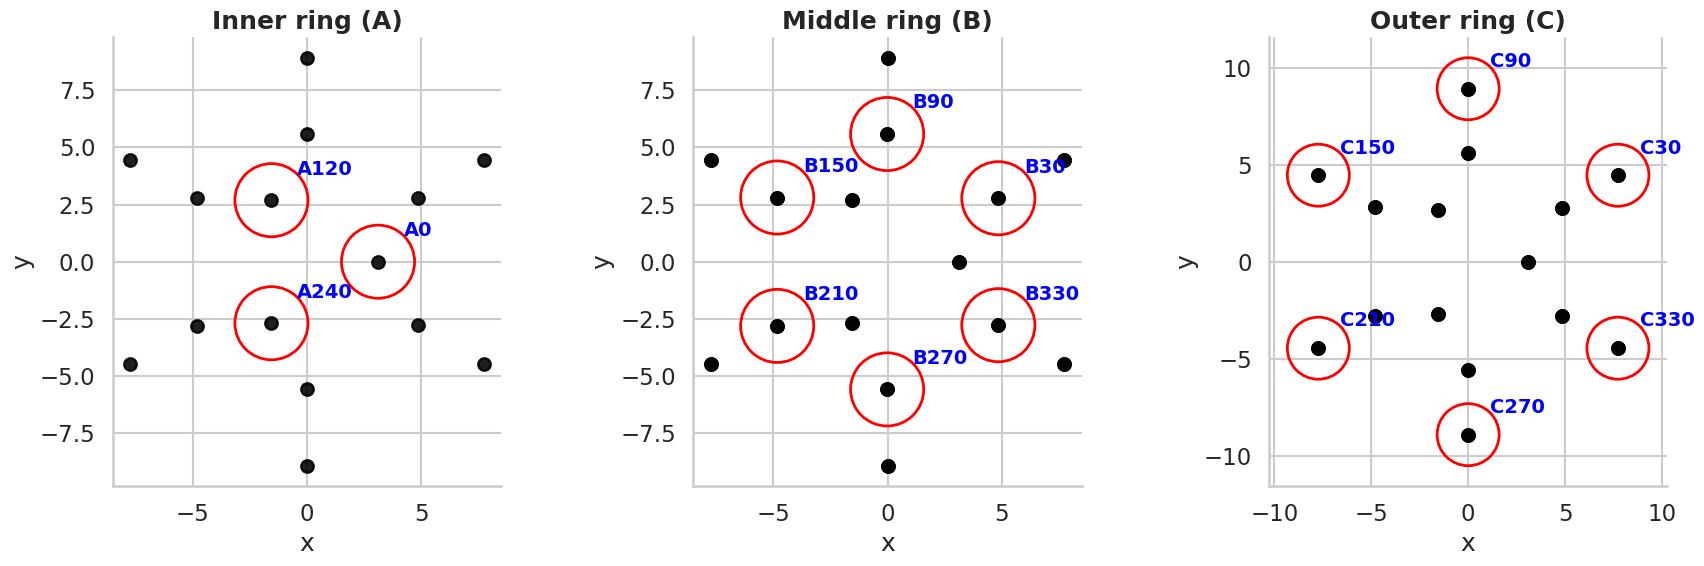


Total clusters: 15


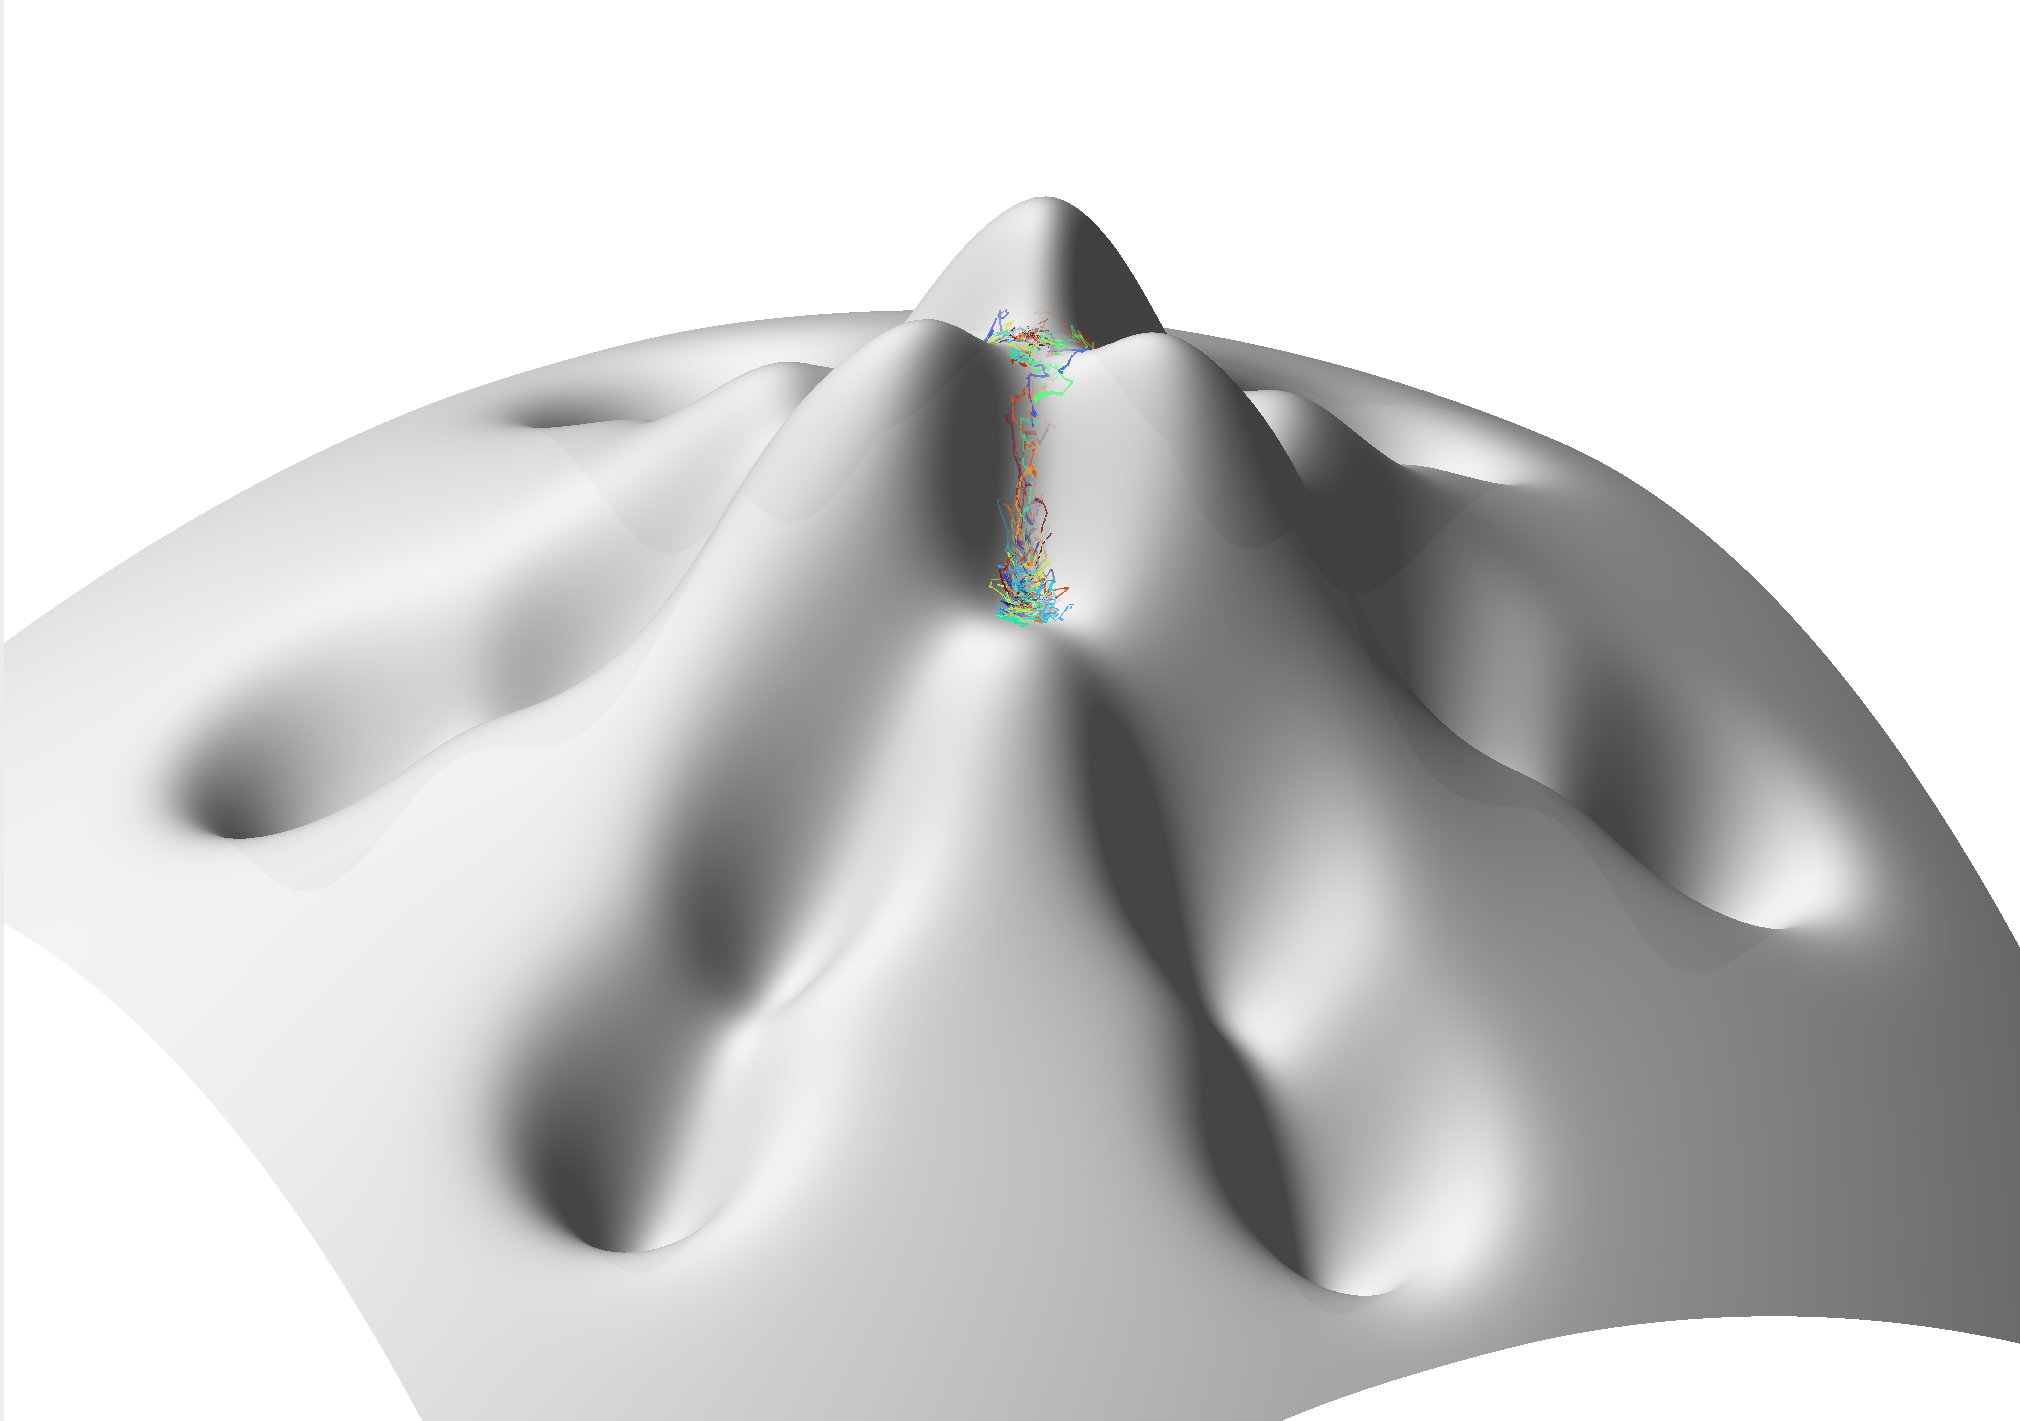

In [35]:
MINIMA_POINTS = minima.find_local_minima()
# local minima of the Waddington landscape
# (+ ASSIGNMENT_RADIUS) determine cell type
cluster_dict = visual.create_cluster_dict_and_plot(
    MINIMA_POINTS,
    ASSIGNMENT_RADIUS)

# If desired, plot all minima points with circles indicating the assignment radius simultaneously
'''
print(f"radius around critical point used to assign cell type: {ASSIGNMENT_RADIUS}")

from matplotlib.patches import Circle

minima_points_np = np.array(MINIMA_POINTS)
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)
plt.figure(figsize=(12, 8))
plt.scatter(minima_points_np[:, 0], minima_points_np[:, 1], c='black')

# Add circles at each minima point
for point in minima_points_np:
    circle = Circle((point[0], point[1]), ASSIGNMENT_RADIUS, fill=False, color='red', linewidth=2)
    plt.gca().add_patch(circle)

plt.gca().set_aspect('equal', adjustable='box')
sns.despine()
plt.title('All cell type regions', fontsize=30, fontweight='bold')
plt.xlabel('x', fontsize=25)
plt.ylabel('y', fontsize=25)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
''';
'''img1 = Image.open('1.png')
img1''';
img = Image.open(fh_hmot + '/experiments/2.png')
img

## running Langevin dynamics, and build ground-truth differentiation map

In [36]:
Xs, Ys, snapshots = simulation.simulate_langevin_with_snapshots(
    n_particles=LANGEVIN_n_particles,
    n_steps=LANGEVIN_N_timesteps,
    dt=LANGEVIN_dt,
    diffusion=LANGEVIN_D,
    snap_times=TIMEPOINTS)

transition_maps, cell_assignments, type_labels = differentiation.build_differentiation_map(
    Xs, Ys, MINIMA_POINTS,
    timepoints=TIMEPOINTS,
    assignment_radius=ASSIGNMENT_RADIUS
)
keys = [f"t{TIMEPOINTS[0]}_to_t{TIMEPOINTS[1]}", f"t{TIMEPOINTS[1]}_to_t{TIMEPOINTS[2]}"]
matrices = [transition_maps[key] for key in keys]
dfs = [pd.DataFrame(mat, index=type_labels, columns=type_labels) for mat in matrices]

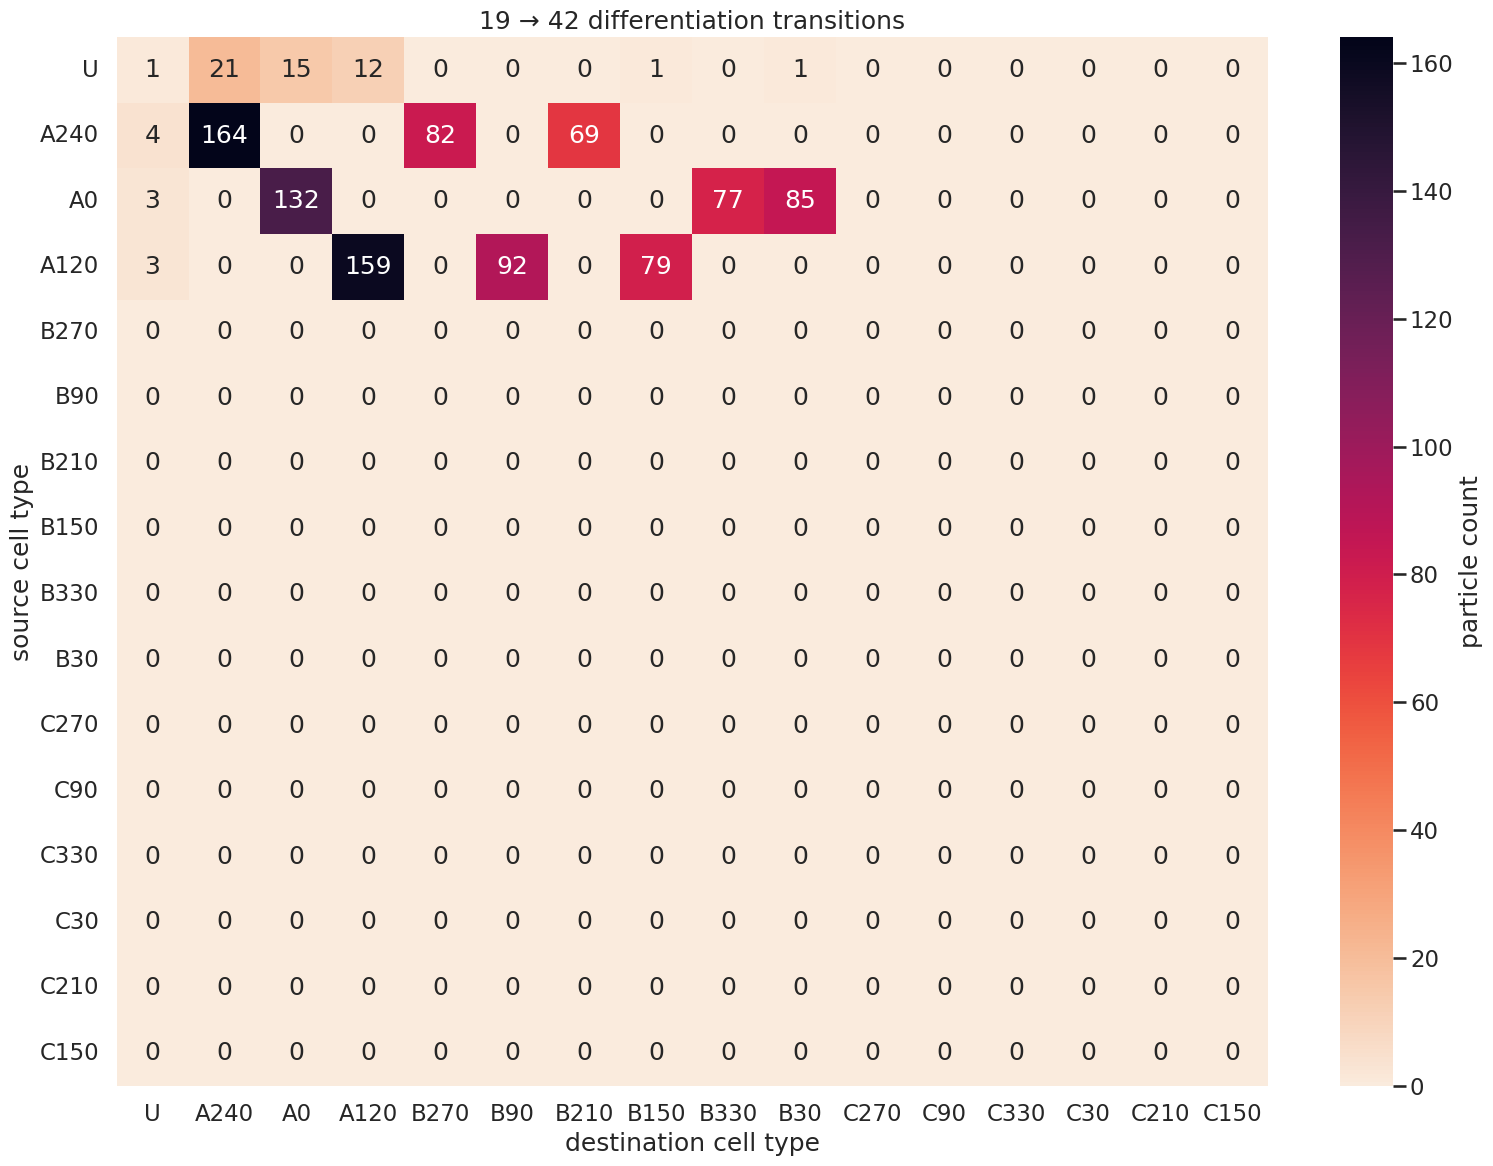

In [37]:
plt.figure(figsize=(16, 12))
sns.heatmap(dfs[0],
            cmap="rocket_r",        # or your favourite palette
            annot=True, fmt="d",    # counts in each cell
            cbar_kws={"label": "particle count"})
plt.title(f"{TIMEPOINTS[0]} → {TIMEPOINTS[1]} differentiation transitions")
plt.ylabel("source cell type")
plt.xlabel("destination cell type")
plt.tight_layout()
plt.show()

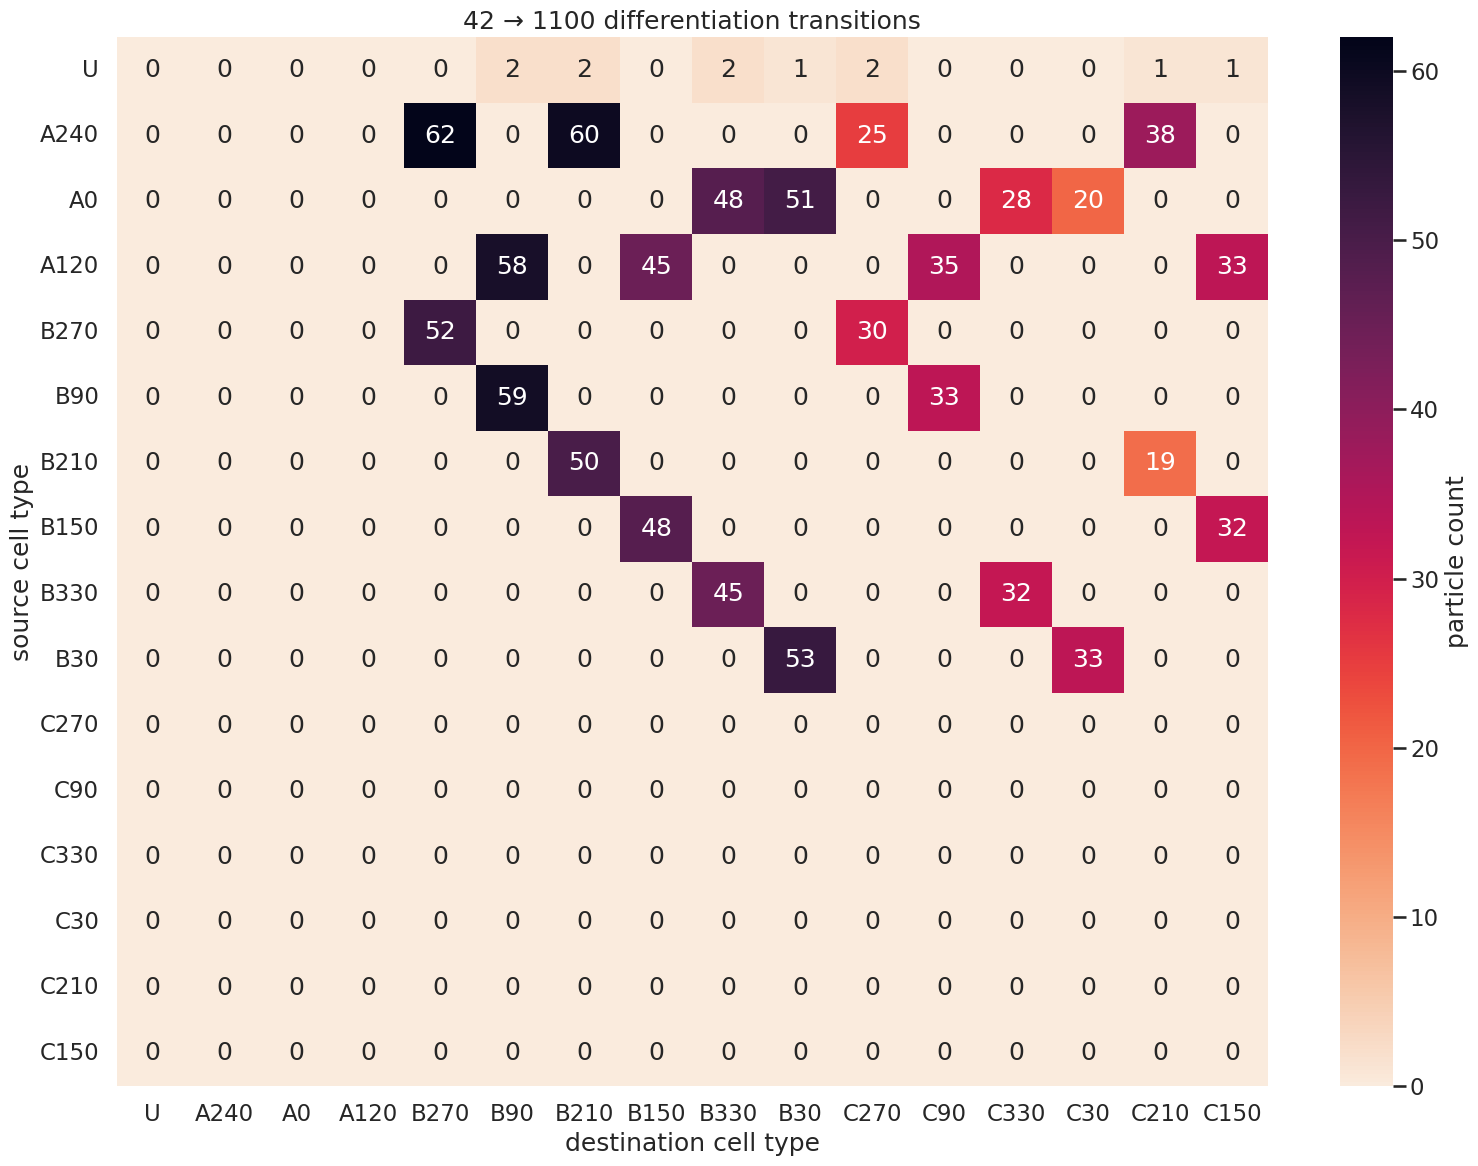

In [38]:
plt.figure(figsize=(16, 12))
sns.heatmap(dfs[1],
            cmap="rocket_r",        # or your favourite palette
            annot=True, fmt="d",    # counts in each cell
            cbar_kws={"label": "particle count"})
plt.title(f"{TIMEPOINTS[1]} → {TIMEPOINTS[2]} differentiation transitions")
plt.ylabel("source cell type")
plt.xlabel("destination cell type")
plt.tight_layout()
plt.show()

## ground truth cell type assignment

In [39]:
snapshots

{'step_19': array([[-1.3813324 , -2.7166595 ],
        [ 3.0502887 ,  0.01270502],
        [-1.6762058 ,  2.7014492 ],
        ...,
        [-1.2955506 ,  2.7414265 ],
        [-2.0598366 , -2.5241516 ],
        [-1.8444831 ,  2.5128934 ]], dtype=float32),
 'step_42': array([[-0.14559451, -4.7057195 ],
        [ 3.559312  ,  1.1182922 ],
        [-3.928162  ,  2.654757  ],
        ...,
        [-0.1085107 ,  5.2909045 ],
        [-4.689875  , -2.6304774 ],
        [-4.646302  ,  2.8042798 ]], dtype=float32),
 'step_1100': array([[ 0.16364808, -9.022333  ],
        [ 7.815743  ,  4.4328375 ],
        [-4.879737  ,  2.8663206 ],
        ...,
        [ 0.05848804,  5.4312086 ],
        [-4.700781  , -2.8519943 ],
        [-4.6675496 ,  2.8206806 ]], dtype=float32)}

In [42]:
Ss = [
    np.stack((Xs[:, t], Ys[:, t]), axis=1)     # shape (N, 2)
    for t in TIMEPOINTS
]

In [43]:
Qs_gt_full =  minima.build_Qs(Ss, MINIMA_POINTS, ASSIGNMENT_RADIUS)

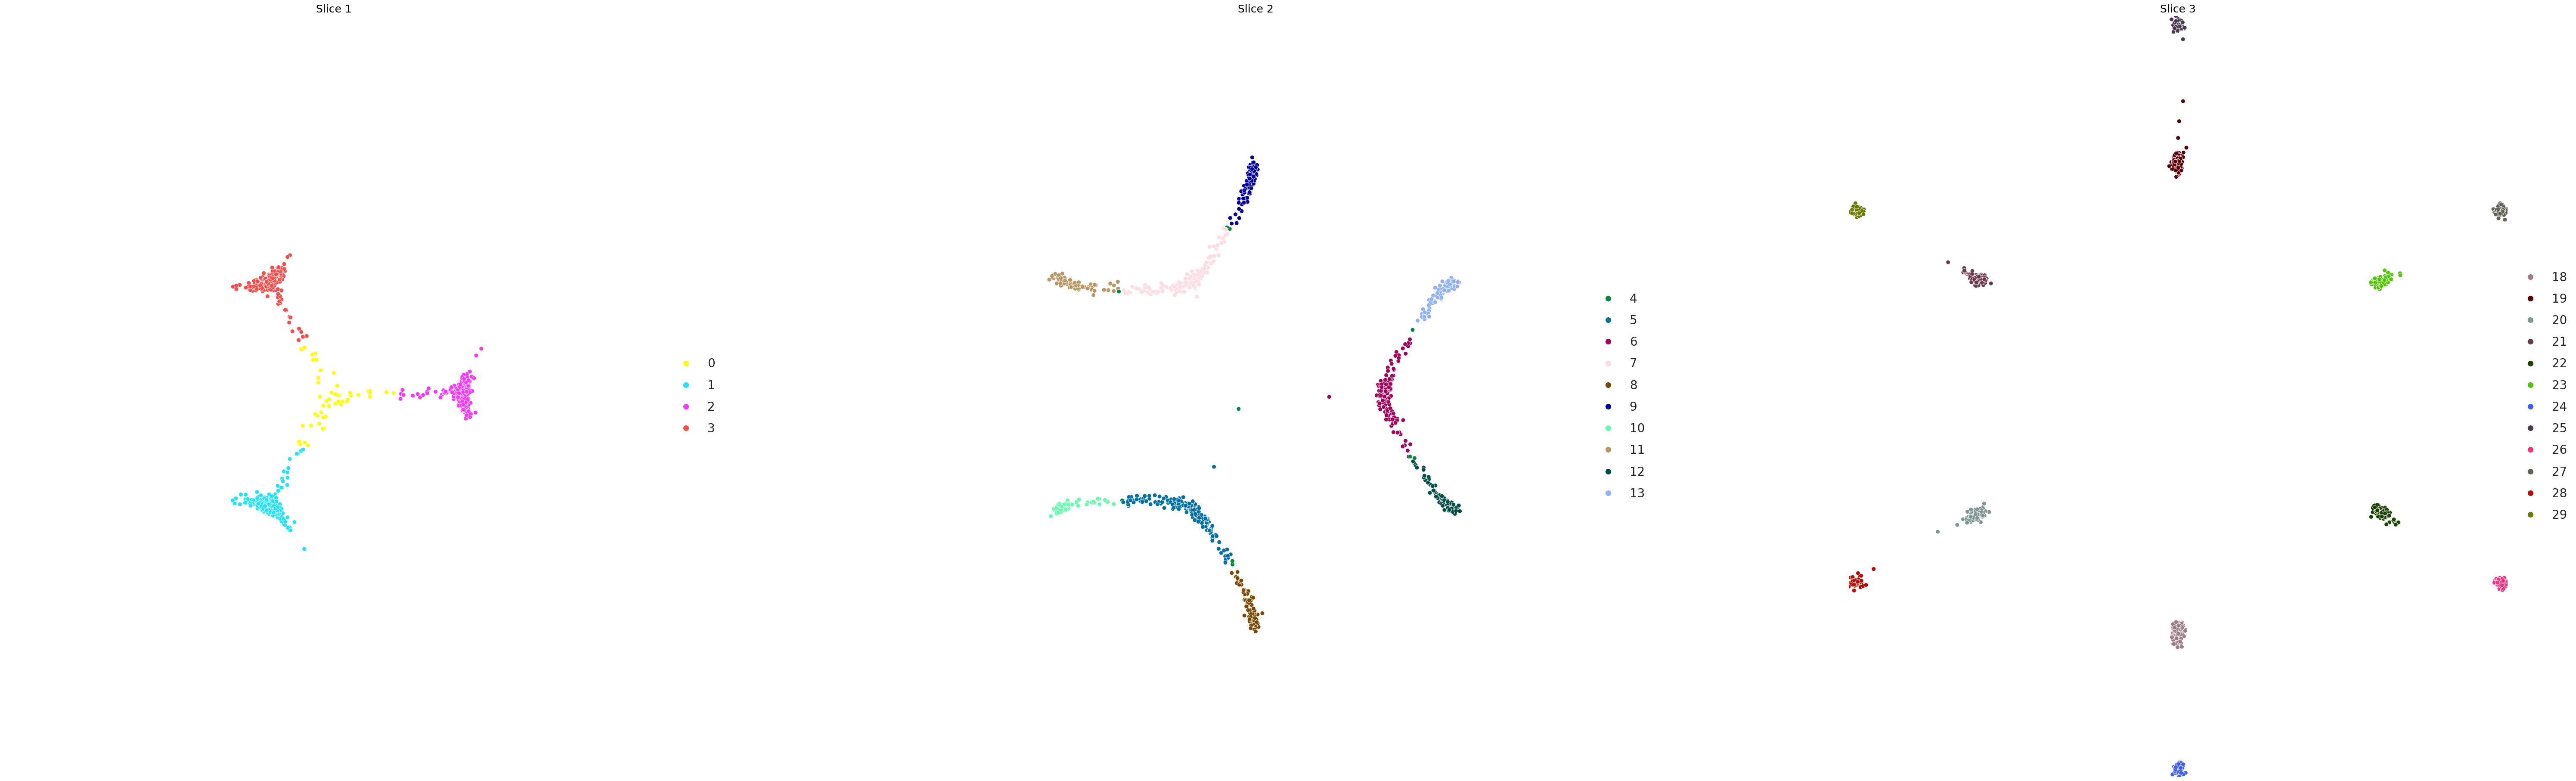

In [44]:
plotting.plot_clusters_from_QT(
    Qs = Qs_gt_full,
    Ts = [None, None],
    Ss=Ss,
    dotsize=50.0,
    key_dotsize=.2)

## visualizeding added measurement noise

In [45]:
STD=0.3
NOISE_min = 1.0 * STD
NOISE_max = 2.0 * STD
n_TIMEPOINTS = len(TIMEPOINTS)

n_noise_levels = 2
noise_level_range = np.linspace(NOISE_min, NOISE_max, n_noise_levels)


# Shape: (n_noise_levels, n_timepoints, n_particles, 2)
all_matrices = np.random.normal(0, 1, size=(n_noise_levels, n_TIMEPOINTS, LANGEVIN_n_particles, 2))

# Scale by noise levels
matrices = {}
for i, level in enumerate(noise_level_range):
    matrices[level] = [all_matrices[i, t] * level for t in range(n_TIMEPOINTS)]

matrix_list = list(matrices.values()) # list, indexed implicitly by noise level
print(f"shape of matrices: {np.array(matrix_list[0]).shape}")

shape of matrices: (3, 1000, 2)


noise level 0 / 2: 0.3


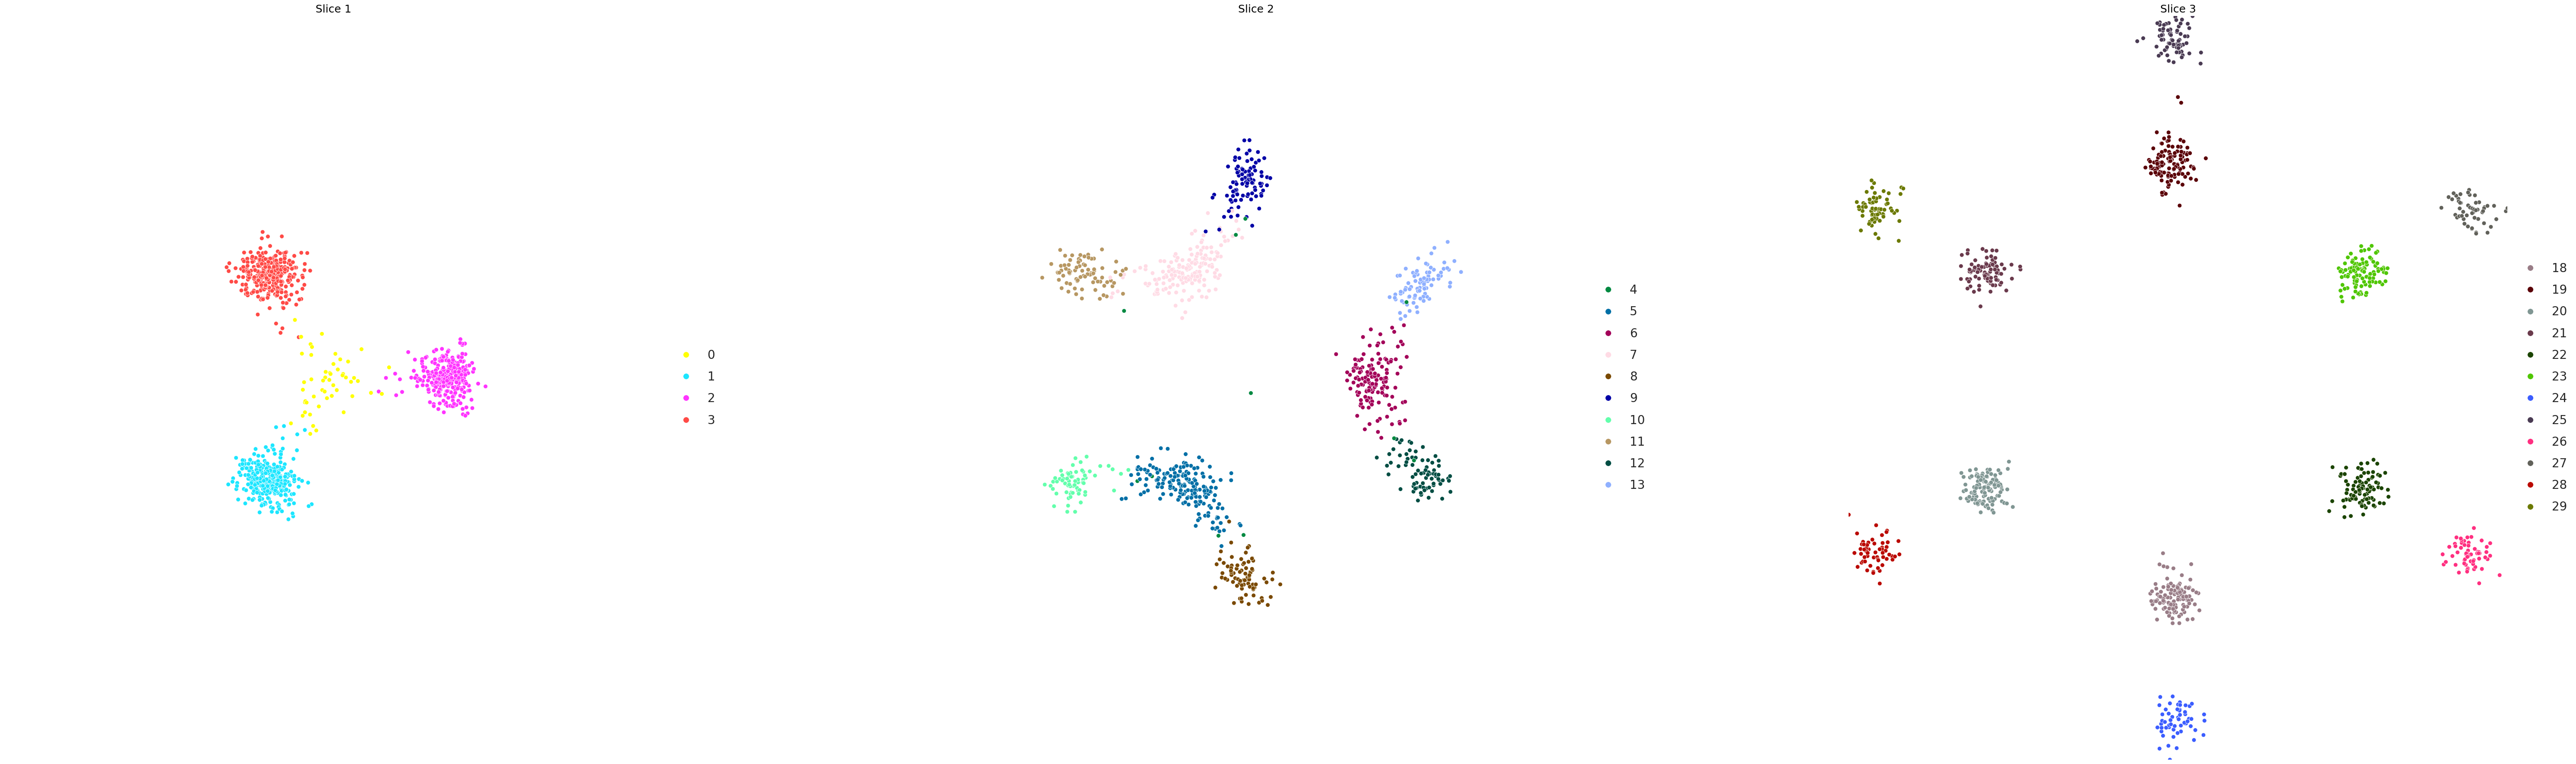

noise level 1 / 2: 0.6


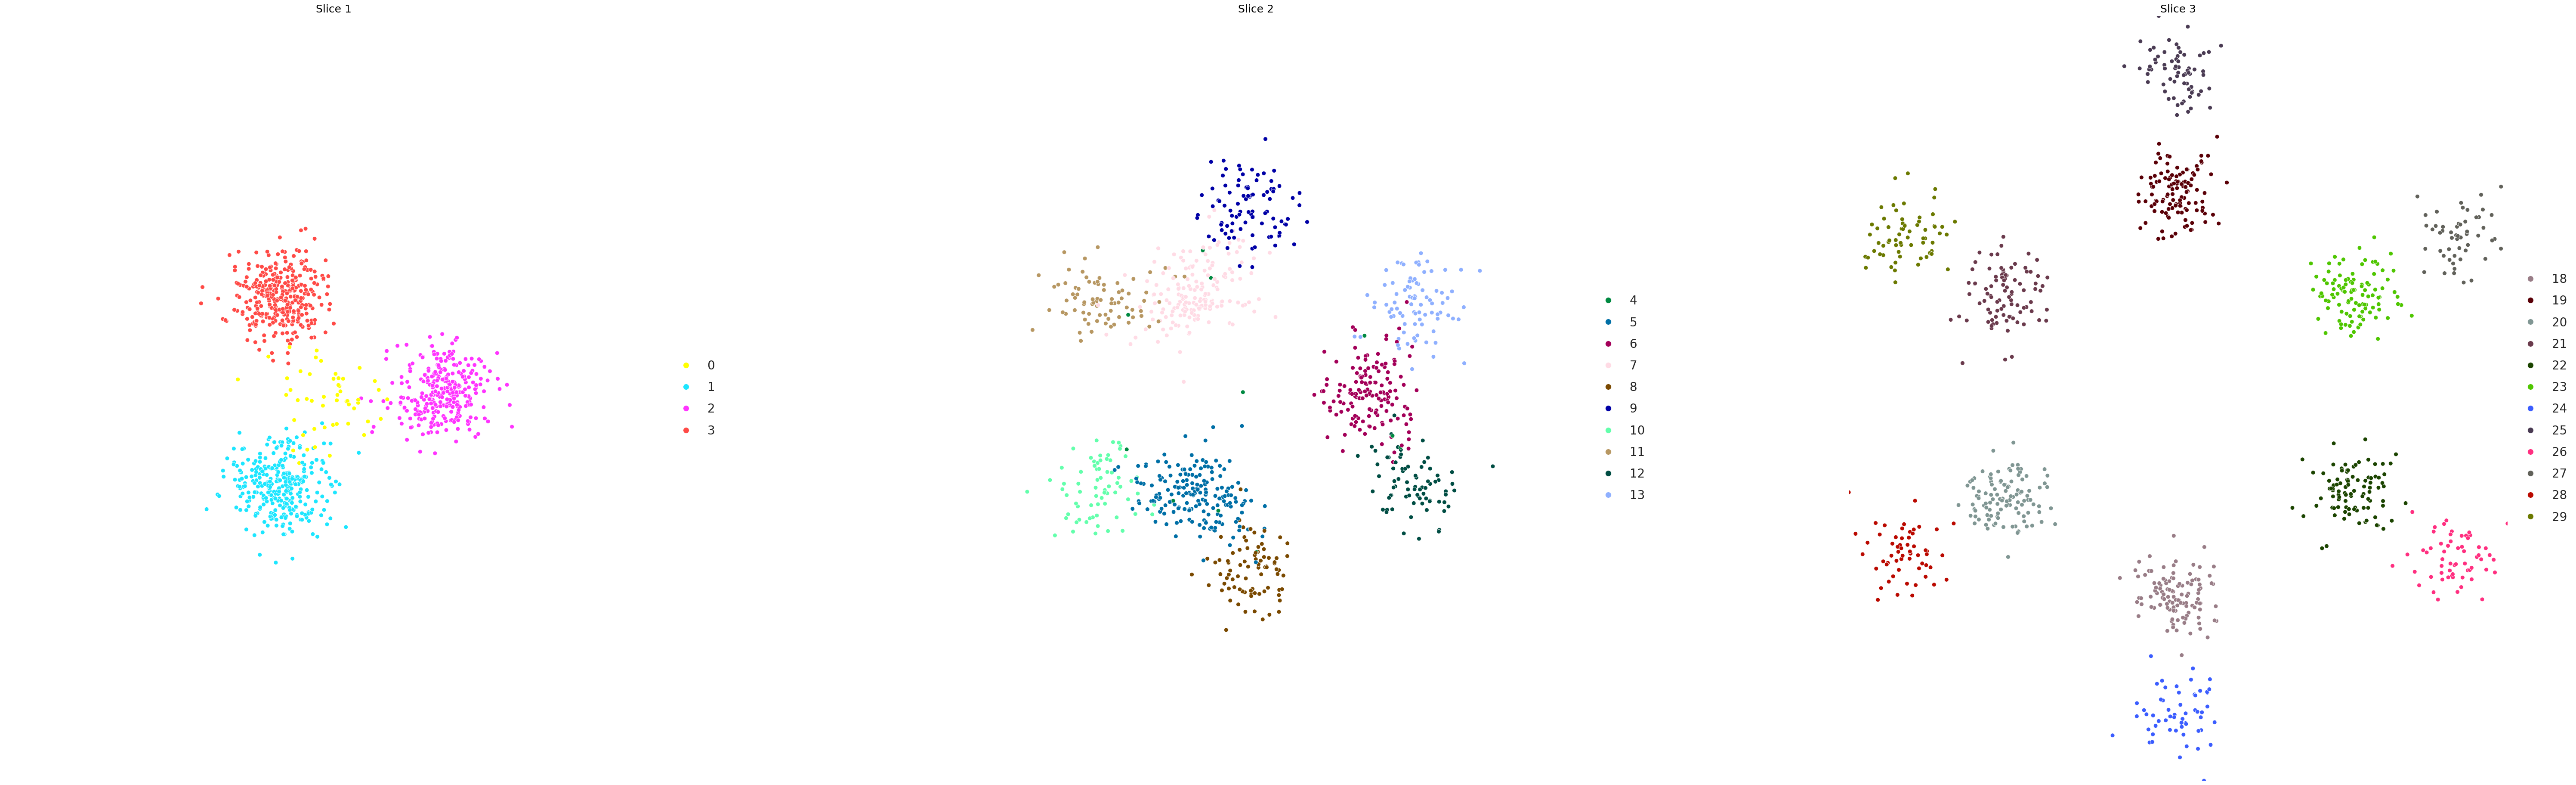

In [46]:
for i, level in enumerate(noise_level_range):
    print(f'noise level {i} / {len(noise_level_range)}: {level}')
    Ss_noisy = [ S + matrices[level][t] for t, S in enumerate(Ss) ]
    plotting.plot_clusters_from_QT(
        Qs = Qs_gt_full,
        Ts = [None, None],
        Ss=Ss_noisy,
        dotsize=50.0,
        key_dotsize=.2)